In [1]:
import sys, os
import os
import torch
import torchvision.transforms as transforms

home_dir = os.path.abspath(os.getcwd()+"/../")
print(home_dir)
sys.path.append(os.path.join(home_dir, 'lib'))
sys.path.append(home_dir)

from lib.models.backbones.vit import ViT
from lib.models.heads import UncertaintyDeconvDepthWiseChannelHead
from lib.models.heads import TopdownHeatmapSimpleHead
from lib.dataset.coco import COCODataset
from lib.core.config import config
from lib.core.config import update_config
# from lib.models.extra.vit_large_uncertainty_config import extra
from lib.models.extra.vit_huge_uncertainty_config import extra

from lib.models.uncertainty_pose import UncertaintyPose
from lib.models.vit_pose import ViTPose

from lib.utils.vis import display_heatamp, display_keypoints, display_keypoints_with_uncertainty, coco_info, skeleton_connection_info
import cv2
import numpy as np


/home/yongju/Github/HPE_HOI/HPE


In [2]:
torch.cuda.is_available()

# update_config(home_dir + '/experiments/coco/vit/vit_large_uncertainty.yaml')
update_config(home_dir + '/experiments/coco/vit/vit_huge_uncertainty.yaml')

## USE_UDP = False 
config.TEST.USE_UDP = False 
config.DATASET.TARGET_KEYPOINT = True
config.DATASET.TARGET_HEATMAP = True

config.TEST.USE_GT_BBOX = True

normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
)
# torch.manual_seed(10)
torch.manual_seed(0)


In [3]:
test_dataset = COCODataset(
    cfg=config, 
    root='/data/coco/', 
    image_set='val2017', 
    is_train=False,
    transform=transforms.Compose(
        [
            transforms.ToTensor(),
        ]
    ),
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=True,
    num_workers=config.WORKERS,
    pin_memory=True,
)



loading annotations into memory...
Done (t=0.15s)
creating index...
index created!
=> num_images: 5000
=> load 6352 samples


In [4]:
from copy import deepcopy
## Backbone - ViT
backbone = ViT(
    img_size=extra["backbone"]["img_size"],
    patch_size=extra["backbone"]["patch_size"],
    embed_dim=extra["backbone"]["embed_dim"],
    in_channels=3,
    num_heads=extra["backbone"]["num_heads"],
    depth=extra["backbone"]["depth"],
    qkv_bias=True,
    drop_path_rate = extra["backbone"]["drop_path_rate"]
)

## HEAD - Heatmap Simple Head
deconv_head = TopdownHeatmapSimpleHead(
    in_channels=extra["keypoint_head"]["in_channels"],
    num_deconv_layers=extra["keypoint_head"]["num_deconv_layers"],
    num_deconv_filters=extra["keypoint_head"]["num_deconv_filters"],
    num_deconv_kernels=extra["keypoint_head"]["num_deconv_kernels"],
    extra=dict(final_conv_kernel=1),
    out_channels=17,
)

## Uncertainty head
uncertainty_head = UncertaintyDeconvDepthWiseChannelHead(
    extra["uncertainty_channel_head"], norm_cfg=dict(type="BN")
)
model = UncertaintyPose(backbone, deconv_head, uncertainty_head, config)
model_official = ViTPose(deepcopy(backbone), deepcopy(deconv_head))

model.eval()
model_official.eval()
# model = model.cuda()

from lib.core.inference import post_dark_udp
from lib.core.inference import get_final_preds

def get_max_preds(heatmaps):
    """
    get predictions from score maps+
    heatmaps: numpy.ndarray([batch_size, num_joints, height, width])
    """
    assert isinstance(heatmaps, np.ndarray), "heatmaps should be numpy.ndarray"
    assert heatmaps.ndim == 4, "batch_images should be 4-ndim"
    N, K, _, W = heatmaps.shape
    heatmaps_reshaped = heatmaps.reshape((N, K, -1))
    idx = np.argmax(heatmaps_reshaped, 2).reshape((N, K, 1))
    maxvals = np.amax(heatmaps_reshaped, 2).reshape((N, K, 1))

    preds = np.tile(idx, (1, 1, 2)).astype(np.float32)
    preds[:, :, 0] = preds[:, :, 0] % W
    preds[:, :, 1] = preds[:, :, 1] // W

    preds = np.where(np.tile(maxvals, (1, 1, 2)) > 0.0, preds, -1)
    return preds, maxvals


In [5]:
checkpoint_path = home_dir + "/checkpoints/vit_huge_77_1.pth.tar" #vit_huge_uncertainty_77_1_AP.pth.tar"
checkpoint_official = home_dir + "/checkpoints/vitpose-h.pth" #vitpose_huge.pth"
model = model.custom_init_weights(model, checkpoint_path)

model_official.init_weights(checkpoint_official)
print()

checkpoint path :  /home/yongju/Github/HPE_HOI/HPE/checkpoints/vit_huge_77_1.pth.tar
Succesfully init weights..
Please verify once again!!
Not applied "seed"
Not applied "epoch"
Not applied "mmcv_version"
Succesfully init weights..
The parameters of the original pretrained model and your model are identical!



In [6]:
test_dataset.transform

Compose(
    ToTensor()
)

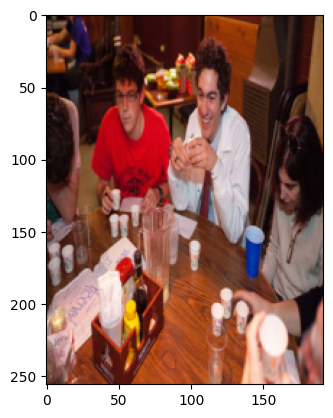

In [7]:
from PIL import Image

img = Image.open("/data/coco/val2017/000000579070.jpg")
import matplotlib.pyplot as plt
#plt.imshow(img.permute(0,2,3,1)[0])

transform = transforms.Compose([ transforms.Resize((256,192)),
                                transforms.ToTensor() ] )

img = transform(img)
img = torch.unsqueeze(img,0)
    
    
plt.imshow(img.permute(0,2,3,1)[0])


# Load Original Image

loading annotations into memory...
Done (t=0.09s)
creating index...
index created!


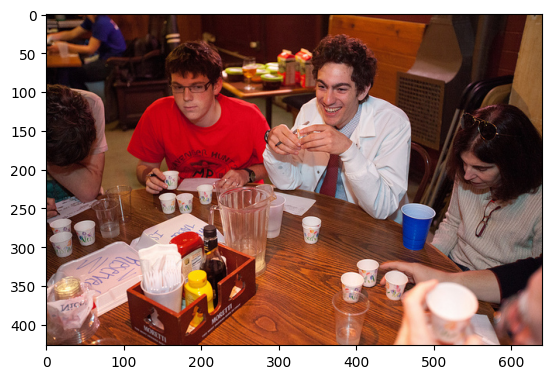

In [8]:
from pycocotools.coco import COCO

annFile='{}/annotations/person_keypoints_{}.json'.format("/data/coco", "val2017")
coco = COCO(annFile)

coco_id=579070
cat_id = coco.getCatIds(catNms=['person'])
ann_id = coco.getAnnIds(imgIds=[int(coco_id)], catIds=cat_id, iscrowd=None)
anns = coco.loadAnns(ids=ann_id[0])

anns_bbox = [ int(x) for x in anns[0]['bbox'] ]
#box = list(np.array([i.numpy() for i in anns_bbox]).reshape(-1))
box = list(np.array([i for i in anns_bbox]).reshape(-1))
    
    
img_orig0 = cv2.imread("/data/coco/val2017/000000579070.jpg")
img_orig0 = cv2.cvtColor(img_orig0,cv2.COLOR_BGR2RGB)

plt.imshow(img_orig0)

In [9]:
anns_bbox = [ int(x) for x in anns[0]['bbox'] ]
anns_bbox

[278, 25, 193, 239]

# Post-Processing For Draw Original Image

bbox는 안다고 가정하고 코드를 작성합니다. bbox : (x,y,w,h)

In [10]:
from lib.utils.transforms import get_affine_transform
from lib.utils.transforms import affine_transform

def box2cs(box):
    x, y, w, h = box[:4]
    return xywh2cs(x, y, w, h)

def xywh2cs(x, y, w, h):
    aspect_ratio = config.MODEL.IMAGE_SIZE[0] * 1.0 / config.MODEL.IMAGE_SIZE[1]
    pixel_std = 200

    center = np.zeros((2), dtype=np.float32)
    center[0] = x + w * 0.5
    center[1] = y + h * 0.5

    if w > aspect_ratio * h:
        h = w * 1.0 / aspect_ratio
    elif w < aspect_ratio * h:
        w = h * aspect_ratio
    scale = np.array([w * 1.0 / pixel_std, h * 1.0 / pixel_std], dtype=np.float32)
    if center[0] != -1:
        scale = scale * 1.25

    return center, scale

In [11]:
def draw_skeleton_origin_img(img, predict_keypoints, uncertainty, bbox, idx=0):
    # print(predict_keypoints)
    plt.imshow(img)
    plt.axis('off')
    ax = plt.gca()
    ax.set_autoscale_on(False)

    uncertainty_thr = 1.5
    print(bbox)
    ## 핵심 
    center, scale = box2cs([bbox[idx + i*len(preds_huge)] for i in range(4)])
    trans = get_affine_transform(center=center, scale=scale, rot=0, output_size=config.MODEL.IMAGE_SIZE, inv=1)
    ## 핵심  

    preds_huge_copy = deepcopy(predict_keypoints)

    # joint 17개 
    for i in range(17):
        preds_huge_copy[idx][i, 0:2] = affine_transform(predict_keypoints[idx][i, 0:2] * 4, trans)    
        
    pred_kp = preds_huge_copy[idx] 
    # print(pred_kp)
    uncertainty = uncertainty[idx]
    x = pred_kp[:,0]
    y = pred_kp[:,1]
    for i, sk in enumerate(skeleton_connection_info['SKELETON']):
        plt.plot(x[sk], y[sk], linewidth=2, color=skeleton_connection_info['COLOR'][i])
        print(x[sk],y[sk])

    plt.plot(x[uncertainty>uncertainty_thr], y[uncertainty>uncertainty_thr],'o',markersize=6, markerfacecolor=[1,0,0], markeredgecolor='k',markeredgewidth=2)
    plt.plot(x[uncertainty<uncertainty_thr], y[uncertainty<uncertainty_thr],'o',markersize=4, markerfacecolor=[1,1,1], markeredgecolor=[0,0,0], markeredgewidth=2)


In [14]:
def infer_hpe(input_img_tensor):
    np.set_printoptions()  # 소수점 이하 자릿수 0, 지수 표현 비활성화

    with torch.no_grad():
        # pose_output = model.forward(img.cuda())
        pose_output = model.forward(input_img_tensor)
        # pose_output_official = model_official.forward(img)

        #g_t_preds, _1 = model.get_max_preds(heatmap.detach().cpu().numpy())

    keys_huge, uncertainty_huge, _, hm_huge = pose_output

    preds_huge, value_huge = get_max_preds(hm_huge.detach().cpu().numpy())

    # preds_huge_official, _ = get_max_preds(pose_output_official.detach().cpu().numpy())


    soft_plus = torch.nn.Softplus()

    uncertainty_map_huge = soft_plus(uncertainty_huge)

    if config.LOSS.USE_INDEXING:
        # kp_ = np.round(target.detach().cpu().numpy() / 4)
        # kp_ = np.round(kLeys_huge.detach().cpu().numpy())
        kp_ = np.round(preds_huge)

        x = np.clip(kp_[:, :, 0], 0, config.MODEL.HEATMAP_SIZE[0] - 1)
        y = np.clip(kp_[:, :, 1], 0, config.MODEL.HEATMAP_SIZE[1] - 1)

        # Uncertainty Map has 1 channel
        sigma_x = torch.diagonal(uncertainty_map_huge[:, 0, y, x], dim1=0, dim2=1).permute(
        1, 0
        )

        uncertainty_huge = torch.cat([sigma_x.unsqueeze(-1), sigma_x.unsqueeze(-1)], dim=-1)

    # get uncertainty 
    sigma_x = sigma_x.detach().cpu().numpy()
    
    return preds_huge, sigma_x


[278, 25, 193, 239]
[394.60416 459.94272] [300.30728 285.22916]
[459.94272 409.68228] [285.22916 280.20312]
[319.21353 294.08334] [300.30728 275.17706]
[294.08334 339.31772] [275.17706 265.125  ]
[409.68228 339.31772] [280.20312 265.125  ]
[444.8646  409.68228] [139.47395 280.20312]
[339.31772 339.31772] [124.395836 265.125   ]
[444.8646  339.31772] [139.47395  124.395836]
[444.8646 434.8125] [139.47395 250.04688]
[339.31772 314.1875 ] [124.395836 219.89062 ]
[434.8125  389.57812] [250.04688 174.65625]
[314.1875  294.08334] [219.89062 174.65625]
[379.52603 354.39584] [99.265625 94.239586]
[364.4479  379.52603] [109.31771   99.265625]
[364.4479  354.39584] [109.31771   94.239586]
[379.52603 409.68228] [99.265625 99.265625]
[354.39584 349.36978] [94.239586 89.21355 ]
[409.68228 444.8646 ] [ 99.265625 139.47395 ]
[349.36978 339.31772] [ 89.21355  124.395836]


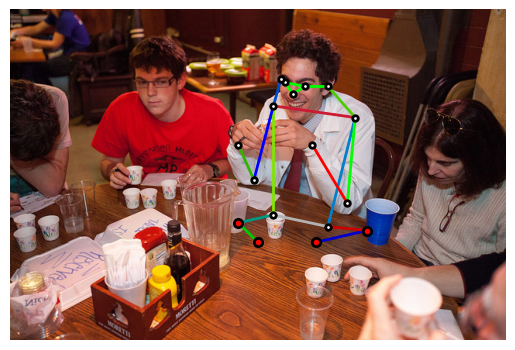

In [34]:
####
img_orig0 = cv2.imread("/data/coco/val2017/000000579070.jpg")
img_orig0 = cv2.cvtColor(img_orig0,cv2.COLOR_BGR2RGB)


img = Image.open("/data/coco/val2017/000000579070.jpg").convert('RGB')
transform = transforms.Compose([ transforms.Resize((256,192)),
                                transforms.ToTensor() ] )

input_img_tensor = transform(img)
input_img_tensor = torch.unsqueeze(input_img_tensor,0)
  


####
idx = 0 
center, scale = box2cs([box[idx + i*len(input_img_tensor)] for i in range(4)])
trans = get_affine_transform(center=center, scale=scale, rot=0, output_size=config.MODEL.IMAGE_SIZE, inv=0)


input_img = cv2.warpAffine(
                img_orig0,
                trans,
                (int(config.MODEL.IMAGE_SIZE[0]), int(config.MODEL.IMAGE_SIZE[1])),
                flags=cv2.INTER_LINEAR,
            )
input_img_tensor = test_dataset.transform(input_img)

input_img_tensor = input_img_tensor.view(1,3,256,192)

preds_huge, sigma_x = infer_hpe(input_img_tensor)



draw_skeleton_origin_img(img_orig0, preds_huge, sigma_x, box, 0)
plt.show()